In [12]:
import numpy as np
import umap
import os
from PIL import Image
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
directory_path = 'iz_embeddings/'

In [3]:
from pathlib import Path

In [4]:
all_names = list(Path('iz').rglob('*.jpg'))
print(len(all_names))

33822


In [9]:
embeddings_list = []

FILE_BATCH_SIZE = 1000
for start in range(0, len(all_names), FILE_BATCH_SIZE):
    file_subset = all_names[start:start+FILE_BATCH_SIZE]
    if len(file_subset) < FILE_BATCH_SIZE:
        file_end = start + len(file_subset)
    else:
        file_end = start + FILE_BATCH_SIZE
    npy_file = f'iz_embeddings/embeddings_{start}_{file_end}.npy'
    embeddings = np.load(npy_file)
    embeddings_list.append(embeddings)
all_embeddings = np.vstack(embeddings_list)
all_embeddings.shape

(33822, 512)

In [13]:
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(all_embeddings)

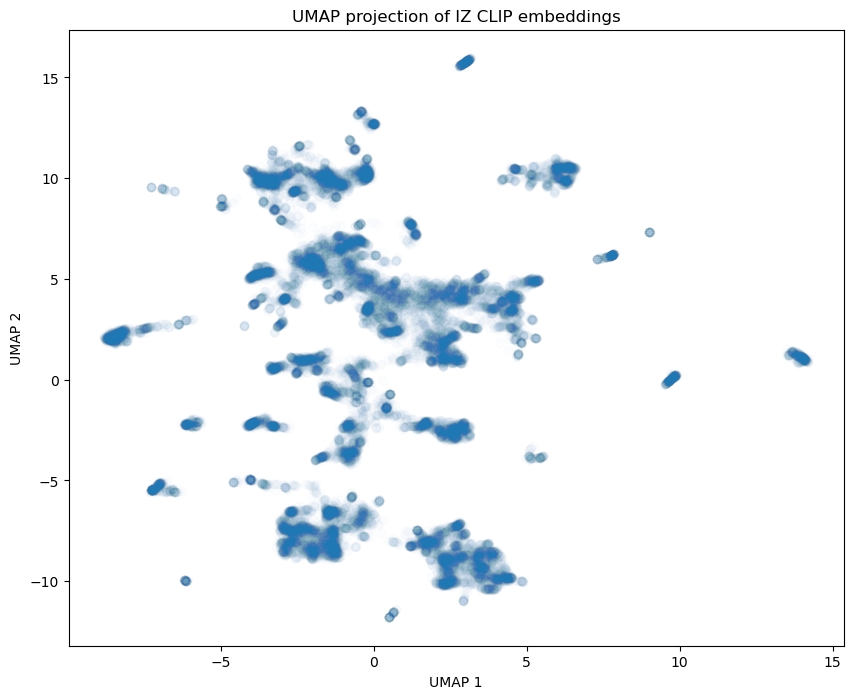

In [22]:
import matplotlib.pyplot as plt

# Assuming 'embedding_umap' contains the UMAP-transformed embeddings

# Plotting the UMAP output
plt.figure(figsize=(10, 8))
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], alpha=0.01)
plt.title('UMAP projection of IZ CLIP embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [23]:
import pandas as pd

In [29]:
filename_list = []

FILE_BATCH_SIZE = 1000
for start in range(0, len(all_names), FILE_BATCH_SIZE):
    file_subset = all_names[start:start+FILE_BATCH_SIZE]
    if len(file_subset) < FILE_BATCH_SIZE:
        file_end = start + len(file_subset)
    else:
        file_end = start + FILE_BATCH_SIZE
    tsv_file = f'iz_probabilities/embeddings_{start}_{file_end}.tsv'
    df = pd.read_csv(tsv_file, sep='\t')
    filenames = df['filename'].tolist()
    filename_list += filenames
len(filename_list)

33822

In [30]:
filename_list[:5]

['m3d9752329-0e64-4b07-ac94-4d373af05f99',
 'm36fb90325-95be-4dd3-b0c3-b65134f1e0eb',
 'm3176c4467-7b0a-4198-b091-6dc40ad8bef0',
 'm34604ba58-9483-4ddc-bec7-81069a4f50d9',
 'm37e39b48a-be5f-4b08-a844-1b814194d3ec']

In [47]:
embedding_normalized = minmax_scale(embedding_umap)
df = pd.DataFrame(embedding_normalized, index=filename_list, columns = ['x','y'])
df.head()

,x,y
m3d9752329-0e64-4b07-ac94-4d373af05f99,0.166832,0.748550
m36fb90325-95be-4dd3-b0c3-b65134f1e0eb,0.391277,0.550199
m3176c4467-7b0a-4198-b091-6dc40ad8bef0,0.314439,0.798820
m34604ba58-9483-4ddc-bec7-81069a4f50d9,0.391110,0.209992
m37e39b48a-be5f-4b08-a844-1b814194d3ec,0.404497,0.000796


In [48]:
df = df.sample(5000)
df.head()

,x,y
m37818ba0d-8261-41f7-9ce7-9c00e07f3cce,0.498668,0.457080
m359702e80-5505-486d-a337-23b35454b0cb,0.075603,0.233349
m313f23586-df7b-46f0-bd7b-313b2c207335,0.491271,0.107205
m31e77db67-dc01-4876-8fc0-52810677967c,0.318734,0.112983
m30f4697b7-bd3a-4566-87b5-016eedaec2bb,0.343758,0.579262


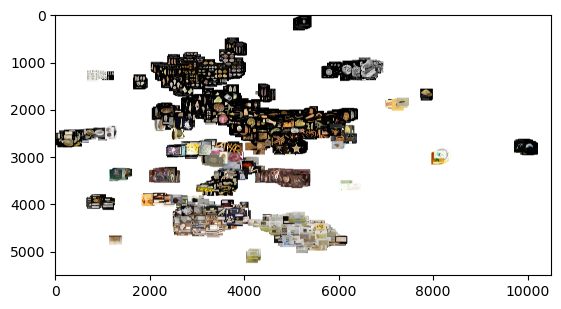

In [49]:
CANVAS_HEIGHT = 5000
CANVAS_WIDTH = 10000
canvas = np.full((CANVAS_HEIGHT+500,CANVAS_WIDTH+500,3),255, dtype=np.uint8)

THUMBNAIL_SIZE = 500,500

for row in df[::-1].itertuples():
    image_path = os.path.join('iz', row.Index) + '.jpg'
    x_pos = round(row.x * CANVAS_WIDTH)
    y_pos = CANVAS_HEIGHT - round(row.y * CANVAS_HEIGHT)

    pil_image = Image.open(image_path)
    pil_image.thumbnail(THUMBNAIL_SIZE)
    np_image = np.array(pil_image)
    if np_image.ndim == 2:
        # Convert grayscale to RGB by stacking the channels
        np_image = np.stack((np_image,)*3, axis=-1)
    canvas[y_pos:np_image.shape[0]+y_pos,
           x_pos:np_image.shape[1]+x_pos] = np_image    
plt.imshow(canvas)

In [50]:
iz_umap = Image.fromarray(canvas)
iz_umap.save('iz_umap.png')